<a href="https://colab.research.google.com/github/di-wu-dw/teamA-grebes-NMA2020/blob/master/20200719_DW_Stringer_Spontaneous_Running_Speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [146]:
#@title Data retrieval
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [147]:
#@title Data loading
import numpy as np
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


In [148]:
#@title import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Ca2+ Activity

[Text(0, 0.5, 'Ca2+ Activity'), Text(0.5, 0, 'Time')]

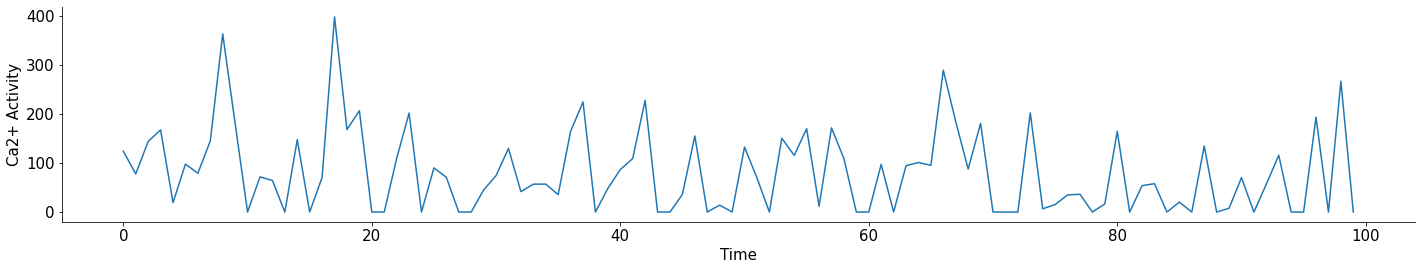

In [149]:
neuron_idx = 134
stop_len = 100
plt.plot(dat['sresp'][neuron_idx,:stop_len])
ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Ca2+ Activity",
)

# Running Speed

[Text(0, 0.5, 'Running Speed [a.u.]'), Text(0.5, 0, 'Time')]

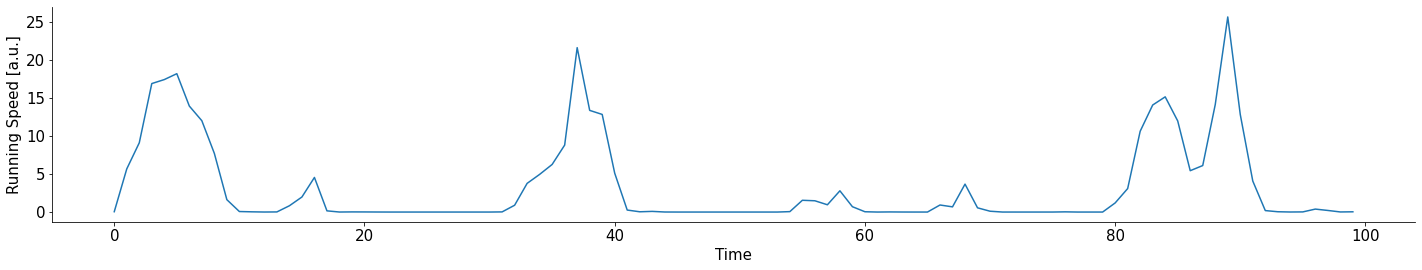

In [150]:
run_thres = 0.5 #cut-off threhold for running speed to be considered running [a.u.]

plt.plot(dat['run'][:stop_len])

t = np.arange(stop_len)

ax = plt.gca()
ax.set(
  xlabel="Time",
  ylabel="Running Speed [a.u.]",
)

# Separate Training and Testing Data

In [151]:
training_len = 5000

X = dat['sresp'][neuron_idx,:training_len]
y = [x[0] for x in dat['run']][:training_len]

[124.36324   77.853355 144.26471  ...  79.61276   36.58307    0.      ]
[0.04362508306767915, 5.688507405467225, 9.130915411829271, 16.939346161708777, 17.465669970633076, 18.242053224847872, 13.974150537990147, 12.040940599972473, 7.733158371832933, 1.6310023042181097, 0.0676667982004092, 0.02925803207644864, 0.0029869994460439606, 0.015443949808996679, 0.8302596173486009, 1.982799360418152, 4.561026515542941, 0.157556323268572, 0.002825664843263263, 0.017605308772558812, 0.013358493236866907, 0.004882464639284443, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.633706550701343e-06, 0.01829856102171772, 0.8976708817789484, 3.7802480413782362, 4.966341688585275, 6.276504696989005, 8.82725707327805, 21.67419005914765, 13.403803698208806, 12.870366133289245, 5.1247769380280905, 0.2629474425851464, 0.035093148323709154, 0.08632548923018658, 0.006090210951035607, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05534641177961345, 1.5508938246137562, 1.486353876196124, 0.958865428708869, 2.80084693

# Apply Temporal Filter

In [152]:
def make_design_matrix(stim, d=20):
  """Create time-lag design matrix from stimulus intensity vector.

  Args:
    stim (1D array): Stimulus intensity at each time point.
    d (number): Number of time lags to use.

  Returns
    X (2D array): GLM design matrix with shape T, d

  """

  # Create version of stimulus vector with zeros before onset
  pad = round(d/2)
  padded_stim = np.concatenate([np.zeros(pad-1), stim, np.zeros(pad)])

  # Construct a matrix where each row has the d frames of
  # the stimulus proceeding and including timepoint t
  T = len(stim)  # Total number of timepoints (hint: total number of stimulus frames)
  X = np.zeros((T, d))
  
  for t in range(T):
      X[t] = padded_stim[t:t+d]

  return X

In [153]:
X_dm = make_design_matrix(X,d=26)
constant = np.ones_like(y)
X_dm = np.column_stack([constant, X_dm])

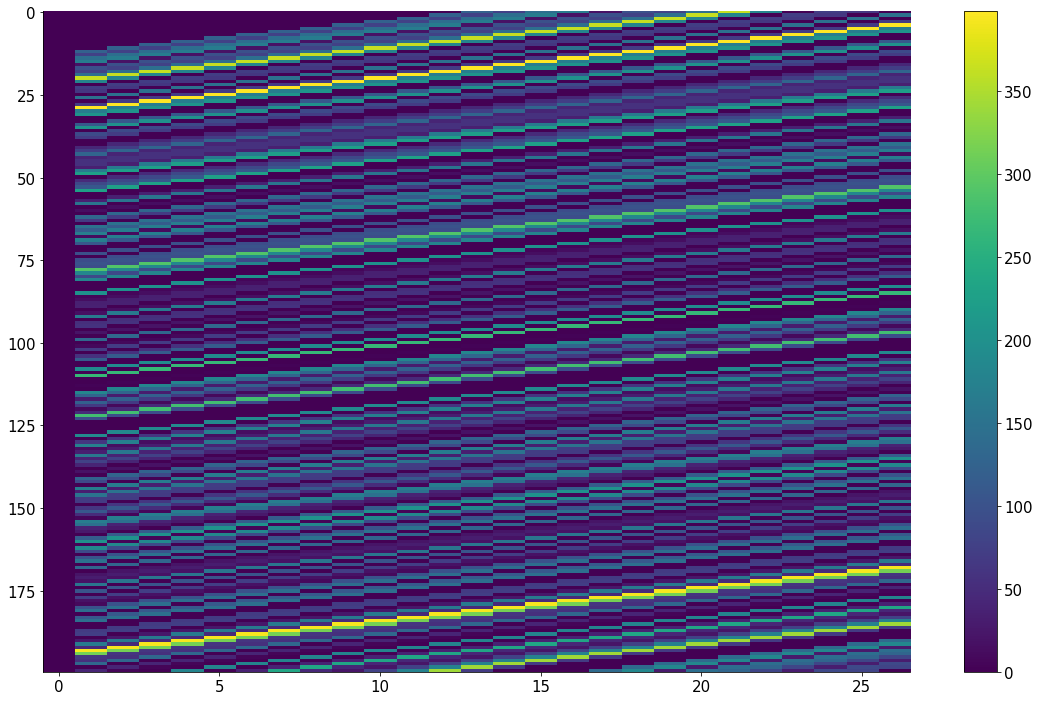

In [154]:
plt.figure(figsize=(16,10))
ax = plt.subplot(1,1,1)
plt.imshow(X_dm[:200,:], aspect = 'auto',cmap = 'viridis')
#ax.set(xlabel = 'timepoints', ylabel = 'neurons')
cbar = plt.colorbar()
#cbar.set_label('Ca2+ activity', rotation=270)

# Gaussian GLM

In [155]:
# Get the MLE weights for the LG model
theta = np.linalg.inv(X_dm.T @ X_dm) @ X_dm.T @ y
theta_lg = theta[1:]

In [156]:
def plot_time_filter(theta, dt, **kws):
  """Plot estimated weights based on time lag model.

  Args:
    theta (1D array): Filter weights, not including DC term.
    dt (number): Duration of each time bin.
    kws: Pass additional keyword arguments to plot()

  """
  d = len(theta)
  t = np.arange(-round(d/2) + 1, round(d/2)+1) * dt

  ax = plt.gca()
  ax.plot(t, theta, marker="o", **kws)
  ax.axhline(0, color=".2", linestyle="--", zorder=1)
  ax.set(
    xlabel="Time relative to Run (s)",
    ylabel="Filter weight",
  )


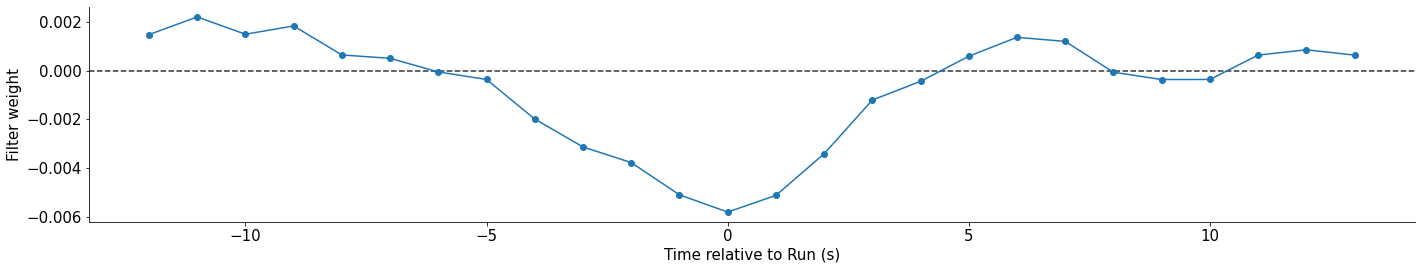

In [157]:
plot_time_filter(theta_lg, 1)